### The logistic map
Is defined as $x_{i + 1} = \alpha x_{i}(1 - x_{i})$. For $\alpha = 4$ it maps $[0,1]$ onto itself. For $\alpha = 4$ the invariant density is $$ \pi(dx) := \frac{1}{\pi\sqrt{x(1 - x)}}dx,$$
which is a beta distribution with parameters $a = b = 0.5$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import beta
import sys
sys.path.append("../../")
from DynamicalSystems.koopman_regression import KernelRidgeRegression, ReducedRankRegression, PrincipalComponentRegression, RandomizedReducedRankRegression
from DynamicalSystems.kernels import Linear, Quadratic, RBF, Matern, Poly
from warnings import warn
#from DynamicalSystems.utils import plot_eigs

In [2]:
"""
statistics = {
    'num_test_samples' :    #Numer of test samples,
    'test_repetitions' :    #(Optional) Number of repetitions of the test,
    'train_repetitions' :   #(Optional) Number of repetitions of the training,
}

parameters = {
    'num_train_samples' :   #Number of training samples or array of training samples,
    'ranks' :               #Rank of the reduced rank approximation or array of ranks,
    'tikhonov_regs':        #Tikhonov regularization parameter or array of regularization parameters,
    'estimators' :          #Estimator or array of estimators,
}
"""
class LogisticMapSimulation:
    def __init__(self, kernel, parameters, statistics, r = 4, sigma = None, iid=True):
        self.kernel = kernel
        self.parameters = parameters
        self.a = 0.5
        self.b = 0.5
        self.r = r
        self.sigma = sigma
        self.iid = iid
        self.test_repetitions = statistics.get('test_repetitions', 1)
        self.train_repetitions = statistics.get('train_repetitions', 1)
        test_size = (statistics['num_test_samples'], self.test_repetitions)
        self.test_set = self._generate_pts(test_size)
        self._parameter_values = ['estimators', 'num_train_samples', 'ranks', 'tikhonov_regs']
        self._is_computed = False
    
    def _unpack_parameters(self):
        iterators = []
        for p_name in self._parameter_values:
            p = self.parameters[p_name]
            if np.ndim(p) == 0:
                p = np.array([p])
            iterators.append(np.array(p))
        return iterators

    def run(self, backend = 'auto'):
        iterators = self._unpack_parameters()
        estimators, num_train_samples, ranks, tikhonov_regs = iterators
        size_err = (2,) #Mean, std    
        for i in iterators:
            size_err += i.shape
        errors = np.zeros(size_err)
        test_X, test_Y = self.test_set
        #Iterate over possible estimators
        for est_i, estimator in enumerate(estimators):
            _first_iter_found = False
            #Iterate over possible training sizes
            _train_iter, _first_iter_found = self._dress_iterator(num_train_samples, estimator.__name__, _first_iter_found)  
            for train_i, num_train in _train_iter:
                X_train, Y_train = self._generate_pts((num_train, self.train_repetitions))
                #Iterate over possible ranks
                _rank_iter, _first_iter_found = self._dress_iterator(ranks, estimator.__name__, _first_iter_found)
                for rank_i, rank in _rank_iter:
                    #Iterate over possible regularization parameters
                    _reg_iter, _first_iter_found = self._dress_iterator(tikhonov_regs, estimator.__name__, _first_iter_found)
                    for reg_i, reg in _reg_iter:
                        _err = np.zeros((self.train_repetitions, self.test_repetitions))
                        #Iterate over train repetitions
                        for train_rep in range(self.train_repetitions):
                            X, Y = X_train[:,train_rep][:,None], Y_train[:,train_rep][:,None]
                            if estimator == KernelRidgeRegression:
                                model = estimator(kernel = self.kernel, tikhonov_reg = reg)
                            else:
                                model = estimator(kernel = self.kernel, rank = rank, tikhonov_reg = reg)
                            model.fit(X, Y, backend = backend)
                            _err[train_rep] = np.array([model.risk(test_X[:,k][:, None], test_Y[:,k][:, None]) for k in range(test_X.shape[1])])
                        errors[0, est_i, train_i, rank_i, reg_i] = np.mean(_err)
                        errors[1, est_i, train_i, rank_i, reg_i] = np.std(_err)
        self._is_computed = True
        self._errors = errors
        return iterators, errors
    
    def _dress_iterator(self, iterator, desc, found):
        _iter = enumerate(iterator)
        if (not found) and (iterator.shape[0] > 1):
                found = True
                _iter = tqdm(_iter, desc = desc, total = iterator.shape[0]) 
        return _iter, found

    def logistic_map(self, x):
        return self.r * x * (1 - x)

    def _generate_pts(self, size):
        if np.isscalar(size):
            size = (size, 1)
        if self.iid:
            X = beta.rvs(self.a, self.b, size = size)
            Y = self.logistic_map(X)
            if self.sigma is not None:
                Y += np.random.normal(scale = self.sigma, size=size)
        else:
            _raw = np.zeros((size[0] + 1, size[1]))
            _raw[0] = beta.rvs(self.a, self.b, size = size[1])
            for i in range(1, size[0] + 1):
                _raw[i] = self.logistic_map(_raw[i - 1])
                if self.sigma is not None:
                    _raw[i] += np.random.normal(scale = self.sigma, size=size[1])
            X = _raw[:-1]
            Y = _raw[1:]
        return X, Y

    def plot1D(self, variables_idx_dict, style= '-' ):
        if not self._is_computed:
            self.run()
        
        for var in self._parameter_values[1:]:
            variables_idx_dict[var] = variables_idx_dict.get(var, 0)
            if variables_idx_dict[var] == None:
                variables_idx_dict[var] = slice(None)
                _var_name = var     
        errors = self._errors[:,:,variables_idx_dict['num_train_samples'], variables_idx_dict['ranks'], variables_idx_dict['tikhonov_regs']]
        iterators = self._unpack_parameters()
        fig, ax = plt.subplots()
        for idx, estimator in enumerate(iterators[0]):       
            mean = errors[0,idx]
            std = errors[1,idx]
            ax.fill_between(self.parameters[_var_name], mean - std, mean + std, alpha = 0.1)
            ax.plot(self.parameters[_var_name], mean, style, label = estimator.__name__)
            ax.margins(0)
            ax.legend(frameon=False)
            ax.set_ylabel("Test error")        
        return fig, ax

In [7]:
kernel = Matern(nu=0.5, length_scale=0.5)
#kernel = RBF(length_scale=0.5)
#kernel = Linear(coef0 = 0.25)

statistics = {
    'num_test_samples' : 100,
    'test_repetitions' : 10,
    'train_repetitions' : 10
}
sigma = 0.1

### Regularization strength

In [8]:
regularization_size = 50
tikhonov_regs = np.geomspace(1e-7, 1e-1, num=regularization_size)

parameters = {
    'num_train_samples' :   100,
    'ranks' :               5,
    'tikhonov_regs':        tikhonov_regs,
    'estimators' :          [PrincipalComponentRegression, ReducedRankRegression, KernelRidgeRegression],
}
simulation = LogisticMapSimulation(kernel, parameters, statistics, sigma = sigma)
iterators, errors = simulation.run(backend = 'cpu')

KernelRidgeRegression: 100%|██████████| 50/50 [00:09<00:00,  5.55it/s]


Text(0.5, 0, 'Tikhonov regularization $\\eta$')

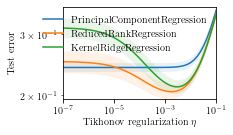

In [9]:
variables_idx_dict = {
    'tikhonov_regs': None
}
fig_width = 5.5/2.0 #Inches
fig_height =fig_width/1.618 #Inches
fig, ax = simulation.plot1D(variables_idx_dict)
fig.set_figheight(fig_height)
fig.set_figwidth(fig_width)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"Tikhonov regularization $\eta$")
#fig.savefig("figs/tikhovov_regs.pdf", bbox_inches='tight')

In [10]:
import dill as pickle
picklefile = open('noisy', 'wb')
#pickle the dictionary and write it to file
pickle.dump((tikhonov_regs, errors), picklefile)
#close the file
picklefile.close()

In [18]:
__useTeX__ = True
if __useTeX__:
    plt.rcParams.update({
        "text.usetex": True,
        #"mathtext.fontset": "ptm",
        "font.family": "serif",
        "font.serif": ["Times"],
        "font.size": 11
    })

### Rank

In [48]:
ranks = np.arange(2, 11 + 1)
parameters = {
    'num_train_samples' :   100,
    'ranks' :               ranks,
    'tikhonov_regs':        3e-3,
    'estimators' :          [PrincipalComponentRegression, ReducedRankRegression],
}

simulation = LogisticMapSimulation(kernel, parameters, statistics, sigma = sigma)
iterators, errors = simulation.run(backend = 'cpu')

ReducedRankRegression: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Text(0.5, 0, 'Rank r')

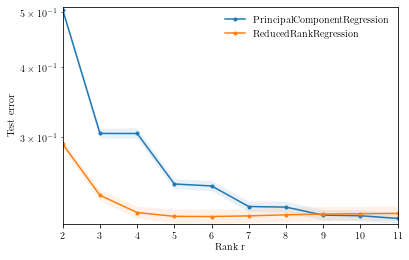

In [49]:
variables_idx_dict = {
    'ranks': None
}
fig, ax = simulation.plot1D(variables_idx_dict, style='.-')
ax.set_yscale('log')
ax.set_xlabel(r"Rank r")

### Num Samples

In [50]:
num_train_samples = np.arange(5, 100,5)
parameters = {
    'num_train_samples' :   num_train_samples,
    'ranks' :               12,
    'tikhonov_regs':        3e-3,
    'estimators' :          [PrincipalComponentRegression, ReducedRankRegression, KernelRidgeRegression],
}

simulation = LogisticMapSimulation(kernel, parameters, statistics, sigma = sigma)
iterators, errors = simulation.run(backend = 'cpu')

KernelRidgeRegression: 100%|██████████| 19/19 [00:12<00:00,  1.49it/s]


Text(0.5, 0, 'Training samples')

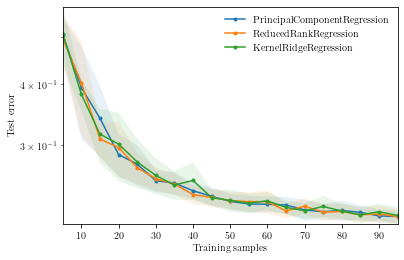

In [51]:
variables_idx_dict = {
    'num_train_samples': None
}
fig, ax = simulation.plot1D(variables_idx_dict, style='.-')
ax.set_yscale('log')
ax.set_xlabel(r"Training samples")